# Advanced grid structure

In this tutorial we will have a more advanced take on the grid structure, specifically the topological information of the grids. 
We recommend reading [grid_structure](./grid_structure.ipynb) before starting on this tutorial.

Before tackling the topological information, we will re-use the basic grid we created in the previous grid structure tutorial:


In [170]:
import numpy as np
import porepy as pp
import inspect

nx = np.array([3, 2])
g = pp.CartGrid(nx)
g.compute_geometry()

And for visualization purposes we also include the same plot as before:

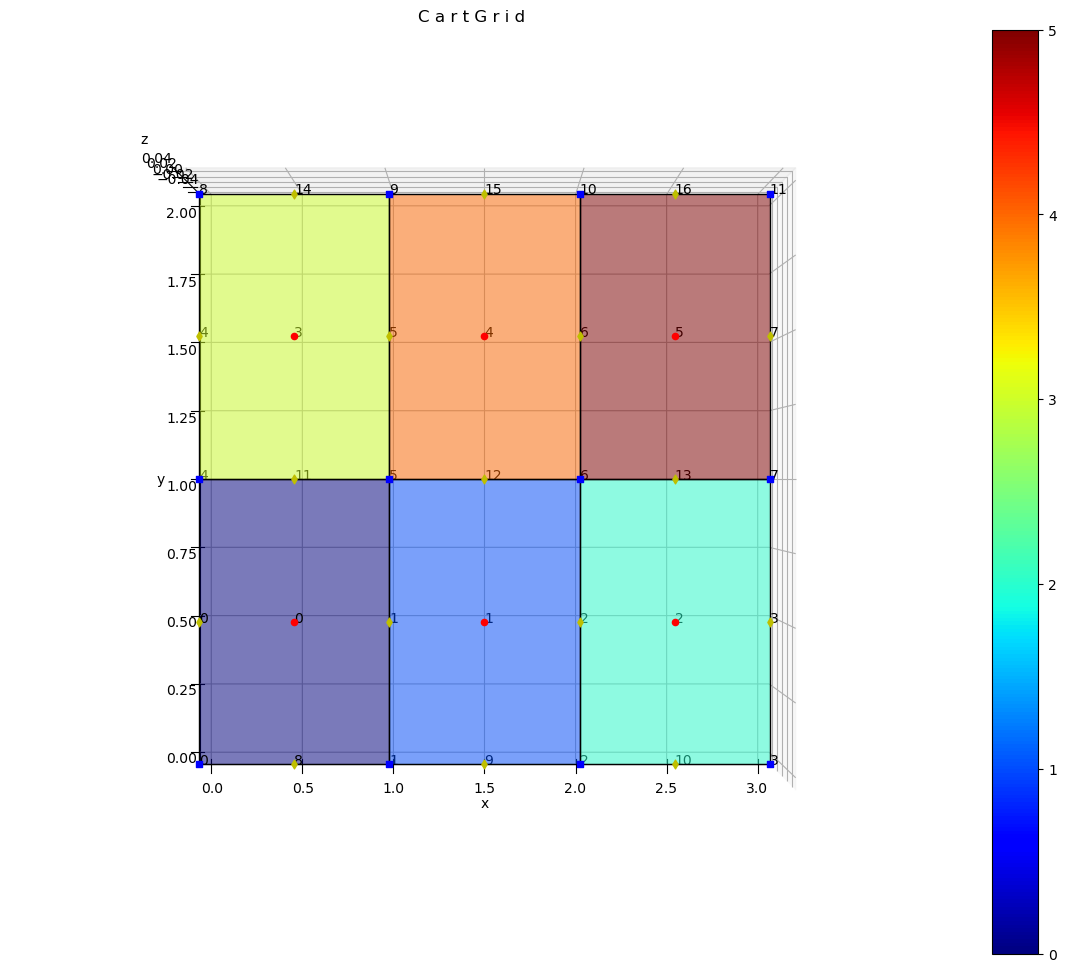

In [171]:
cell_id = np.arange(g.num_cells)
pp.plot_grid(g, cell_value=cell_id, info='cfn', alpha=0.5, figsize=(15,12), plot_2d=True)

For the rest of this tutorial, we will advice the user to sporadically have a look at this plot. 
All the face numbers, node numbers, etc. gathered further down is shown nicely in this figure. 
It can therefore be helpful to use as a visual guide. 

# Topological information

In addition to storing coordinates of cells, faces and nodes, the grid object also keeps track of the relation between them. 
Specifically, we can access:
1. The relation between cells and faces
2. The relation between faces and nodes
3. The direction of `face_normals`, as in which of the neighboring cells has the normal vector as outwards pointing.

Note that there is no notion of edges for 3d grids. 
These are not usually needed for the type of numerical methods that are primarily of interest in `porepy`. 
The information can still be recovered from the face-node relations, see comments below.

The topological information is stored in two attributes, `cell_faces` and `face_nodes`. 
The latter has the simplest interpretation, so we start out with that one:

In [172]:
g.face_nodes

<12x17 sparse matrix of type '<class 'numpy.bool_'>'
	with 34 stored elements in Compressed Sparse Column format>

We see that the information is stored as a scipy.sparse matrix. 
From the shape of the matrix, we conclude that the rows represent nodes, while the faces are stored in columns. 
We can get the nodes for the first face by brute force by writing

In [173]:
np.where(g.face_nodes[:, 0].toarray())[0]

array([0, 4], dtype=int64)

That was hardly elegant, though, and would make for cumbersome implementation of, say, a numerical method. 
A better approach is to utilize the csc storage format, and write

In [174]:
g.face_nodes.indices[g.face_nodes.indptr[0] : g.face_nodes.indptr[1]]

array([0, 4])

For clarity we will also present an example of gathering the node numbers of another face, specifically face number four:

In [175]:
g.face_nodes.indices[g.face_nodes.indptr[3] : g.face_nodes.indptr[4]]

array([3, 7])

To see why this works, confer the scipy.sparse documentation. 
Getting the faces of a node can be done by converting `g.face_nodes` to a csr_matrix, and then follow the above procedure.



The map between cells and faces is stored in the same way, thus the faces of cell 0 is found by

In [176]:
faces_of_cell_0 = g.cell_faces.indices[g.cell_faces.indptr[0] : g.cell_faces.indptr[1]]
print(faces_of_cell_0)

[ 0  1  8 11]


However, `cell_faces` also keeps track of the direction of the normal vector relative to the neighboring cells, by storing data as $\pm 1$, or zero if there is no connection between the cells (in contrast, `face_nodes` simply consist of '`True` or `False`).

In [177]:
g.cell_faces.data[g.cell_faces.indptr[0] : g.cell_faces.indptr[1]]

array([-1.,  1., -1.,  1.])

Compare this with the face normal vectors, which can either be gathered in an array or shown using `pp.plot_grid`:

In [178]:
g.face_normals[:g.dim, faces_of_cell_0]

array([[1., 1., 0., 0.],
       [0., 0., 1., 1.]])

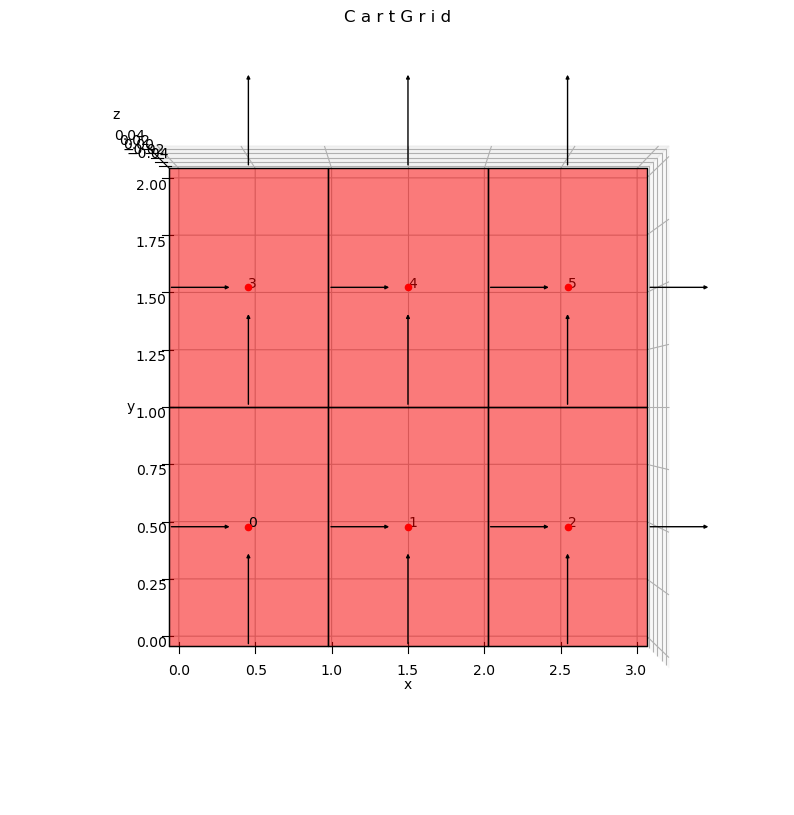

In [179]:
pp.plot_grid(g, info='co', alpha=0.5, figsize=(10, 12))

As can be seen from both the normal vector array and the figure, we observe that positive data corresponds to the normal vector pointing out of the cell. 
This is a very useful feature, since it in effect means that the transpose of `g.cell_faces` is the discrete divergence operator for the grid.



As with the face-node relations, we can obtain the cells of a face by representing the matrix in a sparse row storage format, and then use the above procedure of indices and index pointers. 
However, we know that there will be either 1 or 2 cells adjacent to each face. 
It is thus feasible to create a dense representation of the cell-face relations:

In [180]:
g.cell_face_as_dense()

array([[-1,  0,  1,  2, -1,  3,  4,  5, -1, -1, -1,  0,  1,  2,  3,  4,
         5],
       [ 0,  1,  2, -1,  3,  4,  5, -1,  0,  1,  2,  3,  4,  5, -1, -1,
        -1]])

Here, each column represents the cells of a face, and a negative value signifies that the face is on the boundary, i.e., the face has only one neighboring cell. 
The cells are ordered so that the normal vector points from the cell in row 0 to that in row 1.

Finally, we note that to get a cell-node relation, we can combine `cell_faces` and `face_nodes`. 
However, since `cell_faces` contains both positive and negative values, we need to take the absolute value of the data. This procedure is implemented in the method `cell_nodes()`, which returns a sparse matrix that can be handled in the usual way

In [181]:
print(inspect.getsource(g.cell_nodes))
cn = g.cell_nodes()
cn.indices[cn.indptr[0] : cn.indptr[1]]

    def cell_nodes(self) -> sps.csc_matrix:
        """Obtain mapping between cells and nodes.

        Returns:
            An array with ``shape=(num_nodes, num_cells)`` representing the mapping from
            cells to nodes spanning respective cell.

            The value 1 indicates a connection between a cell and node column-wise.

        """
        mat = (self.face_nodes * np.abs(self.cell_faces)) > 0
        return mat



array([0, 1, 4, 5], dtype=int32)